# EDT only, scaled FI and closed labels

### note: the colorbar labels on the prediction images are incorrect and should read 'normalized EDT feature input' instead of 'EDT [m]'

## modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import time

2023-10-31 20:42:01.846284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 20:42:02.415415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## loss plot function

In [2]:
def learning_progress(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    ground_iou = history.history["binary_io_u"]
    val_ground_iou = history.history["val_binary_io_u"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_dpi(200)
    ax[0].semilogy(epochs, loss, "b", label="Training loss")
    ax[0].plot(epochs, val_loss, "r", label="Validation loss")
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(epochs, ground_iou, "b", label="Training IoU")
    ax[1].plot(epochs, val_ground_iou, "r", label="Validation IoU")
    ax[1].set_title("Training and validation IoU")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("IoU")
    ax[1].grid()
    ax[1].legend()
    plt.show()

## EDT2

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_binary_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)], 
)

checkpoint_filepath = 'edt2_b_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 18:58:22.121342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 18:58:22.126376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 18:58:22.126487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 18:58:27.213034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 18:58:27.271358: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 18:58:31.644083: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa6e004caf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 18:58:31.644103: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 18:58:31.647248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 18:58:31.691759: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 18:58:31.728852: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 52s 810ms/step - loss: 0.1872 - binary_io_u: 0.3981 - val_loss: 0.3468 - val_binary_io_u: 0.0000e+00
Epoch 2/50
38/38 [==============================] - 24s 646ms/step - loss: 0.0632 - binary_io_u: 0.6634 - val_loss: 0.2187 - val_binary_io_u: 0.0000e+00
Epoch 3/50
38/38 [==============================] - 25s 654ms/step - loss: 0.0468 - binary_io_u: 0.7031 - val_loss: 0.1887 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 24s 641ms/step - loss: 0.0403 - binary_io_u: 0.7139 - val_loss: 0.1877 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0333 - binary_io_u: 0.7490 - val_loss: 0.1945 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 25s 655ms/step - loss: 0.0296 - binary_io_u: 0.7652 - val_loss: 0.1550 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0272 - binary_io

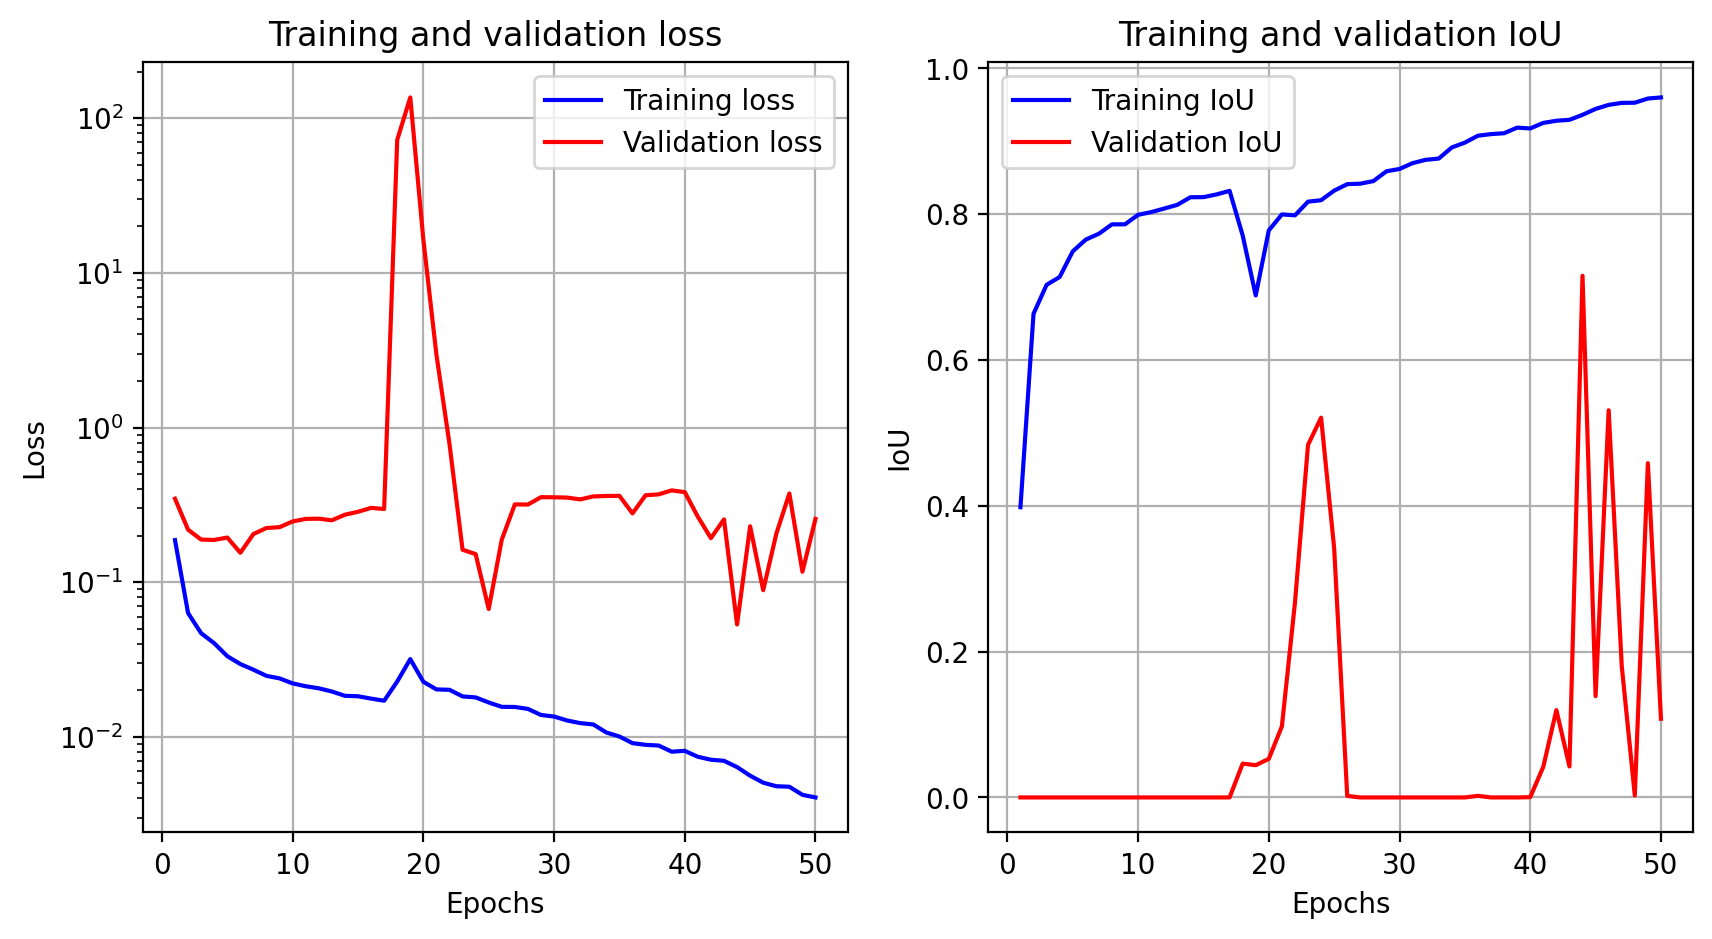

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt2_b_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 64ms/step
Mean IoU = 0.84952414
Binary IoU = 0.84952414
Binary IoU for class 1 = 0.7155622
Binary IoU for class 0 = 0.98348606


1/1 [==============================] - 1s 660ms/step


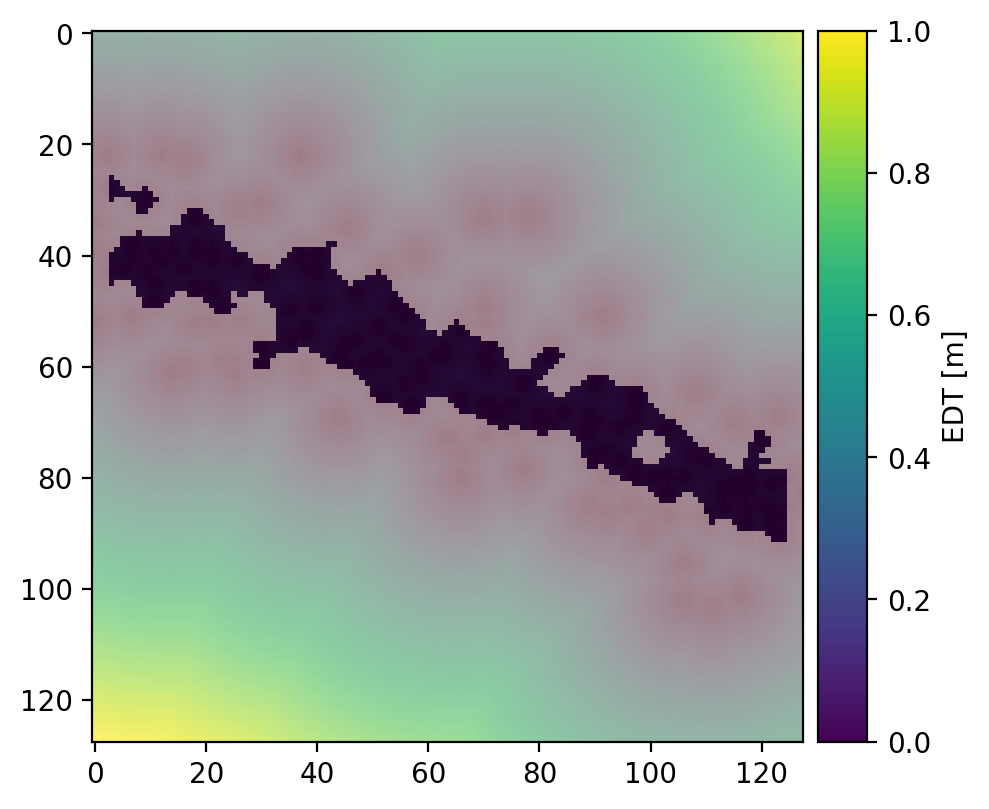

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

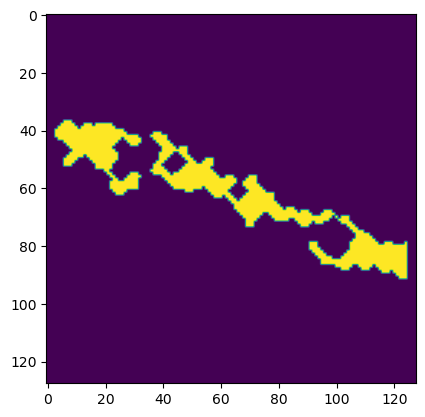

In [7]:
plt.imshow(y_test[1])

In [14]:
model.save(
    "unet-global-px%i-bs%i-lr%0.3f-ep%i_%i-kde-edt-combined.keras"
    % (input_shape[0], batch_size, learning_rate, epochs, x_train.shape[0])
)

pd.DataFrame.from_dict(history.history).to_csv('history_edt_comb.csv',index=False)

## EDT3

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_binary_EDT3_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)], 
)

checkpoint_filepath = 'edt3_b_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 19:20:09.258913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:20:09.263559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:20:09.263668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 19:20:14.435314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 19:20:14.496196: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:20:18.868485: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd38951b630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 19:20:18.868504: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 19:20:18.871805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 19:20:18.915453: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:20:18.952412: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 51s 800ms/step - loss: 0.2439 - binary_io_u: 0.4469 - val_loss: 0.4418 - val_binary_io_u: 4.9775e-05
Epoch 2/50
38/38 [==============================] - 24s 638ms/step - loss: 0.0803 - binary_io_u: 0.7761 - val_loss: 0.3029 - val_binary_io_u: 0.0000e+00
Epoch 3/50
38/38 [==============================] - 24s 647ms/step - loss: 0.0599 - binary_io_u: 0.7980 - val_loss: 0.2755 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 17s 456ms/step - loss: 0.0497 - binary_io_u: 0.8051 - val_loss: 0.2801 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 458ms/step - loss: 0.0425 - binary_io_u: 0.8138 - val_loss: 0.2842 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 459ms/step - loss: 0.0382 - binary_io_u: 0.8168 - val_loss: 0.3044 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 460ms/step - loss: 0.0336 - binary_io

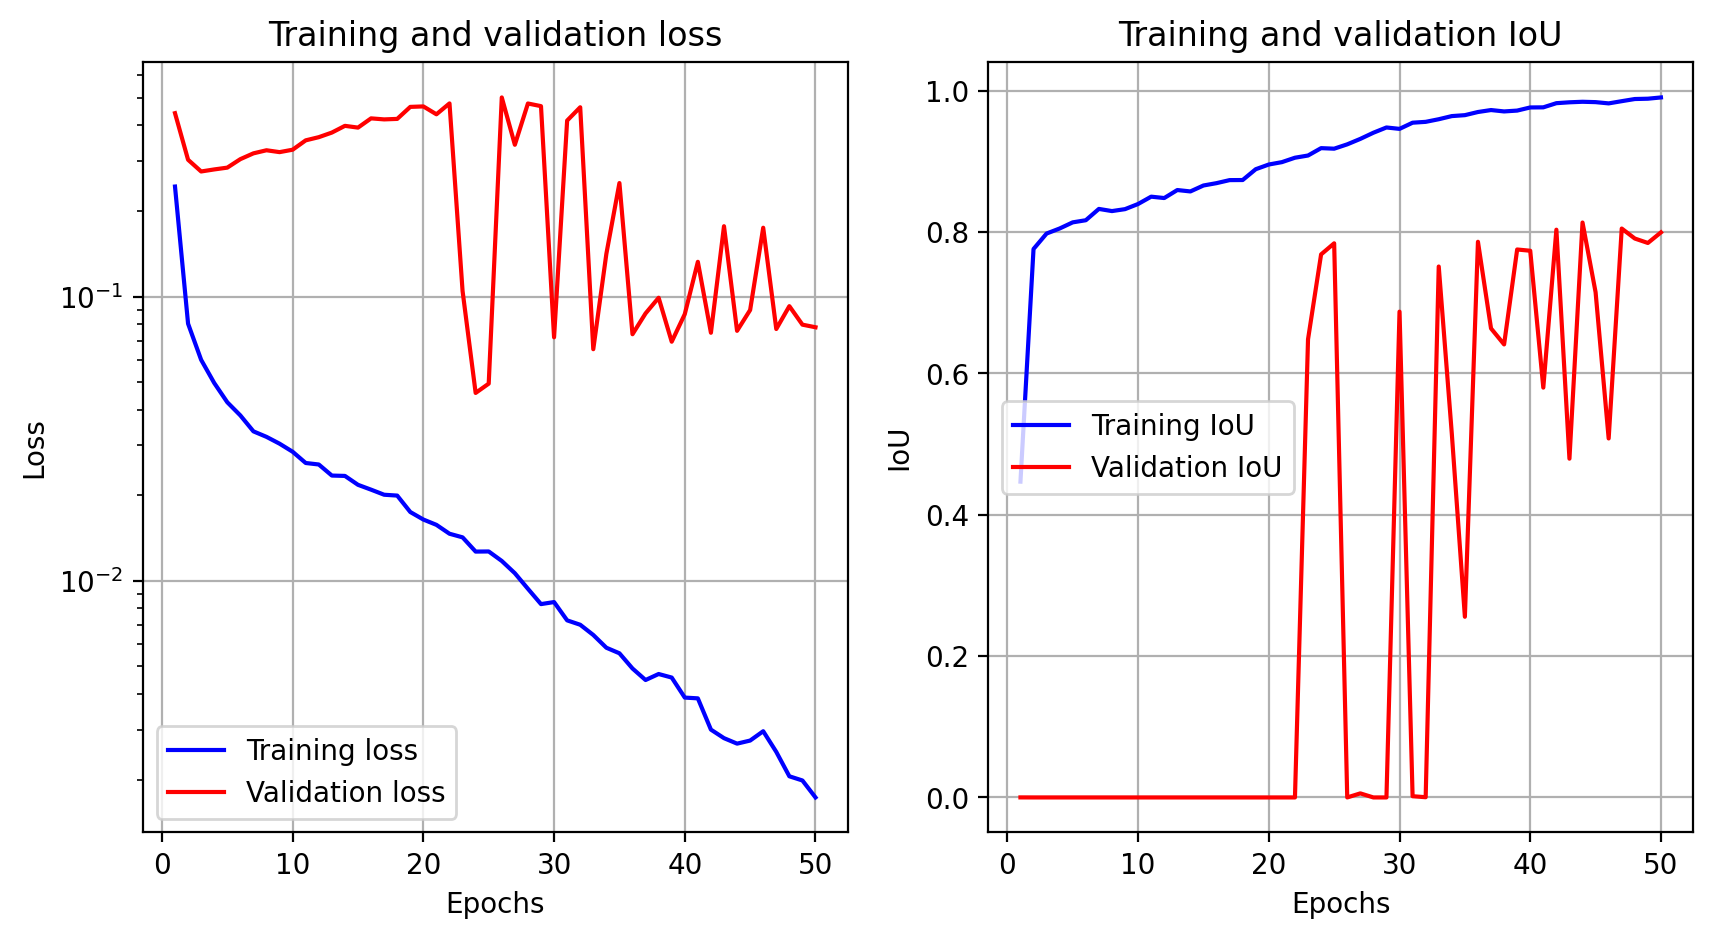

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt3_b_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.8745351
Binary IoU = 0.8745351
Binary IoU for class 1 = 0.7684357
Binary IoU for class 0 = 0.9806344


1/1 [==============================] - 1s 657ms/step


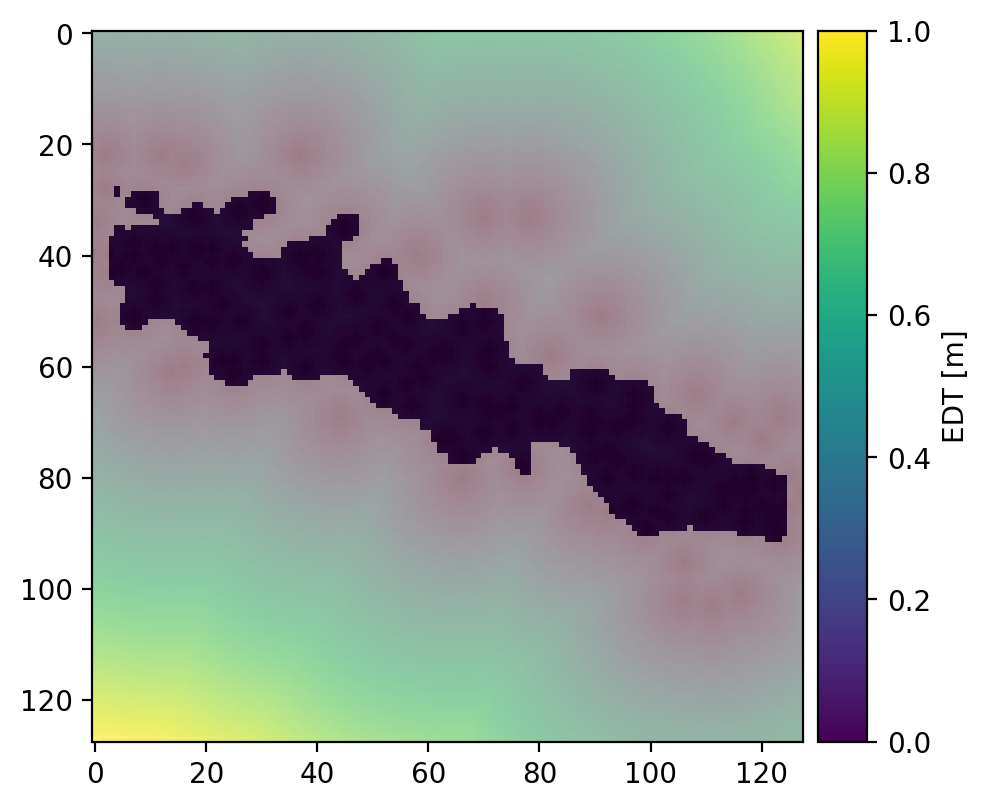

In [6]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT4

In [ ]:
kf = 0

data = np.load("../labelmaking/all_scaled_binary_EDT4_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],  
)

checkpoint_filepath = 'edt4_b_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 19:38:00.660327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:38:00.665709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:38:00.665837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 19:38:05.696418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 19:38:05.755389: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:38:10.172607: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9938612150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 19:38:10.172627: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 19:38:10.176036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 19:38:10.219948: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:38:10.257010: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 52s 810ms/step - loss: 0.2109 - binary_io_u: 0.5563 - val_loss: 1.8844 - val_binary_io_u: 0.0943
Epoch 2/50
38/38 [==============================] - 24s 642ms/step - loss: 0.0760 - binary_io_u: 0.8141 - val_loss: 1.5696 - val_binary_io_u: 0.1292
Epoch 3/50
38/38 [==============================] - 24s 644ms/step - loss: 0.0578 - binary_io_u: 0.8304 - val_loss: 0.2682 - val_binary_io_u: 0.2413
Epoch 4/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0477 - binary_io_u: 0.8395 - val_loss: 0.3157 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 458ms/step - loss: 0.0426 - binary_io_u: 0.8406 - val_loss: 0.3416 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 459ms/step - loss: 0.0380 - binary_io_u: 0.8475 - val_loss: 0.3343 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 459ms/step - loss: 0.0350 - binary_io_u: 0.8524 -

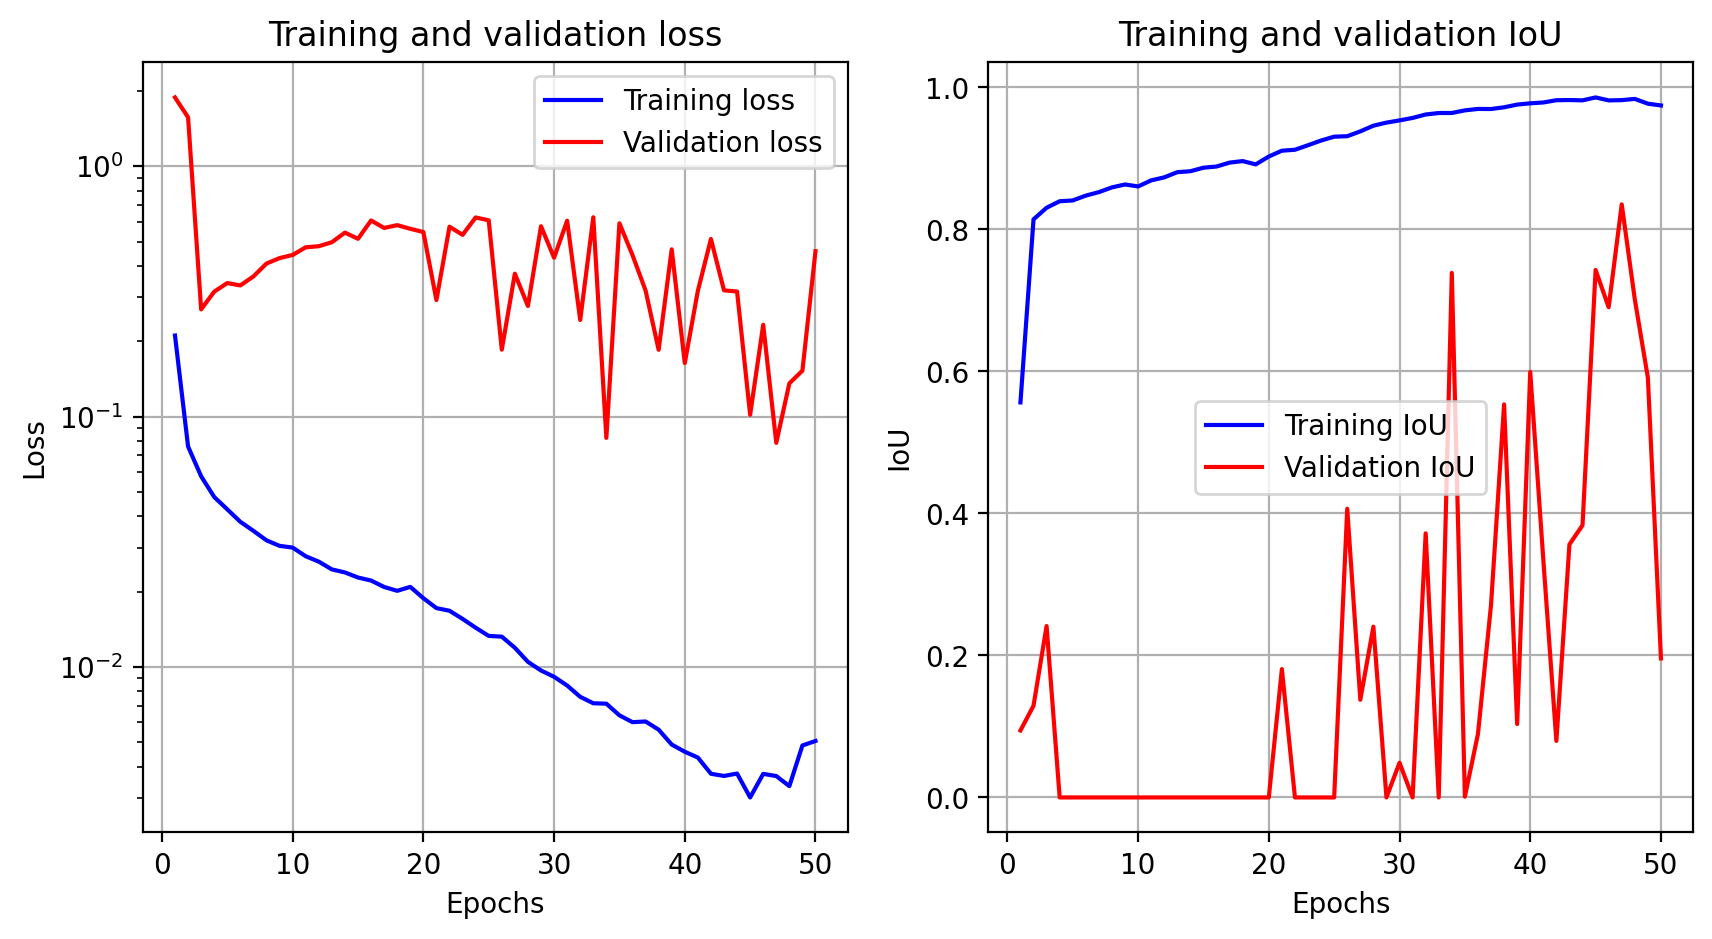

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt4_b_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.90949756
Binary IoU = 0.90949756
Binary IoU for class 1 = 0.8351545
Binary IoU for class 0 = 0.98384064


1/1 [==============================] - 1s 650ms/step


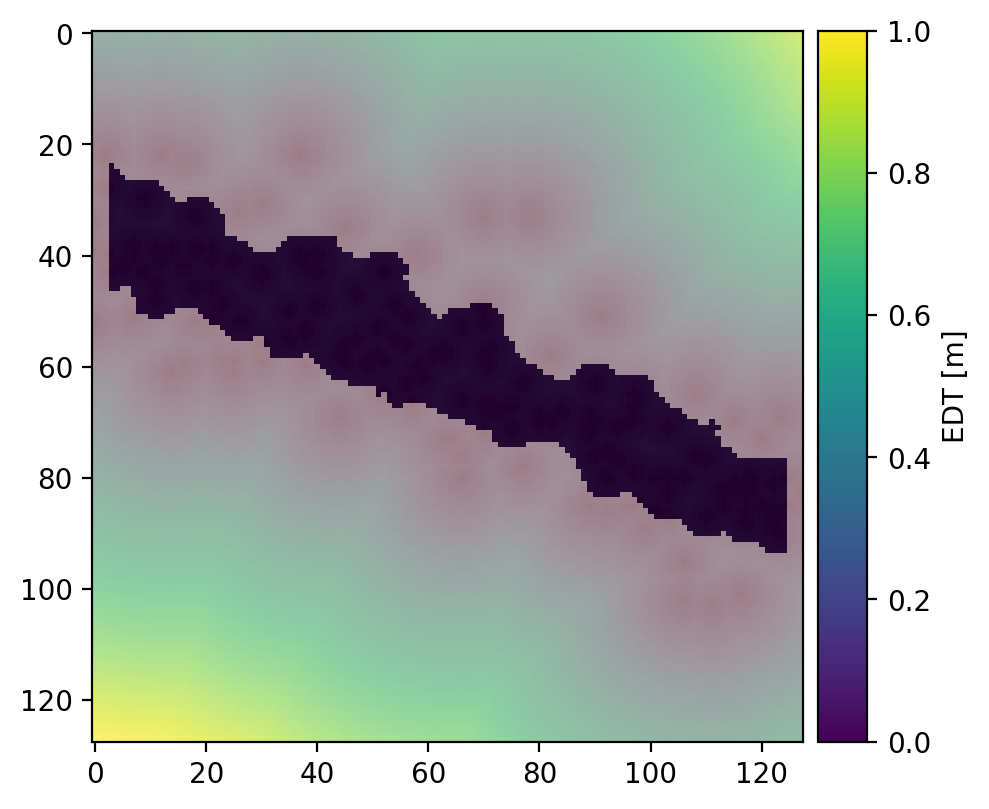

In [6]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT5

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_binary_EDT5_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],  
)

checkpoint_filepath = 'edt5_b_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 19:58:06.660310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:58:06.665784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 19:58:06.665916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 19:58:11.762809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 19:58:11.822213: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:58:16.205453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6ceee142f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 19:58:16.205474: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 19:58:16.208591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 19:58:16.252376: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 19:58:16.289485: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 52s 806ms/step - loss: 0.2098 - binary_io_u: 0.6116 - val_loss: 1.1905 - val_binary_io_u: 0.0014
Epoch 2/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0747 - binary_io_u: 0.8246 - val_loss: 0.3601 - val_binary_io_u: 0.0000e+00
Epoch 3/50
38/38 [==============================] - 25s 669ms/step - loss: 0.0585 - binary_io_u: 0.8393 - val_loss: 0.3337 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 17s 455ms/step - loss: 0.0504 - binary_io_u: 0.8441 - val_loss: 0.3519 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0446 - binary_io_u: 0.8515 - val_loss: 0.3558 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 458ms/step - loss: 0.0405 - binary_io_u: 0.8578 - val_loss: 0.3930 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 459ms/step - loss: 0.0370 - binary_io_u: 

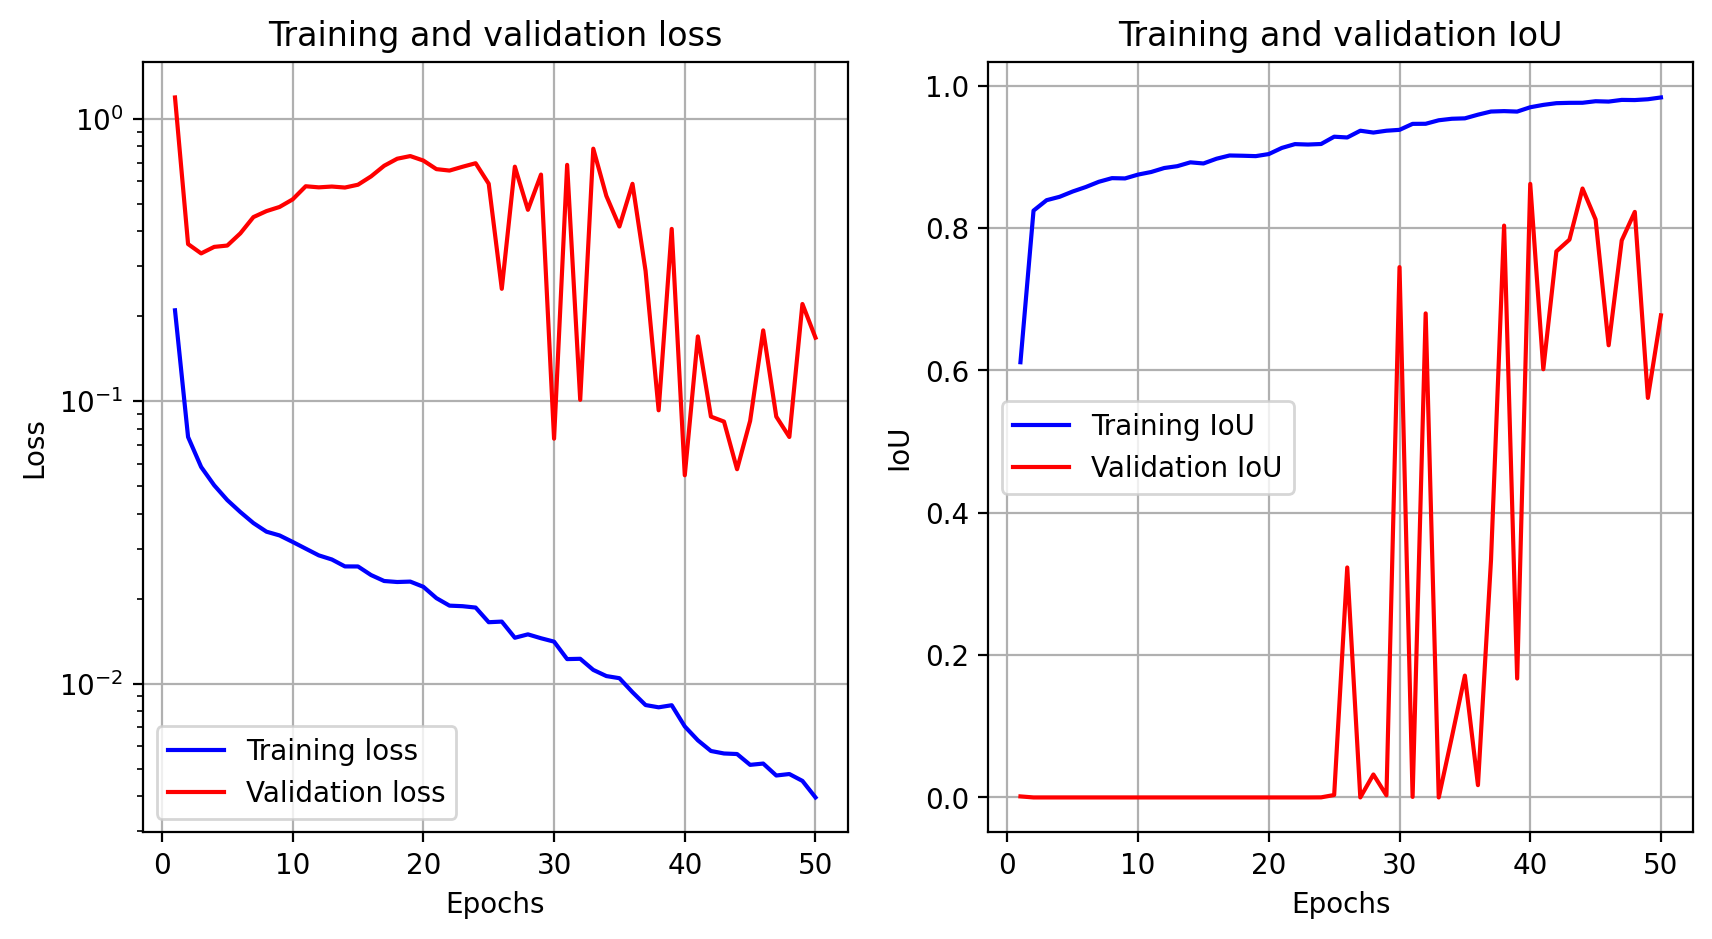

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt5_b_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.9230534
Binary IoU = 0.9230534
Binary IoU for class 1 = 0.8622242
Binary IoU for class 0 = 0.9838826


1/1 [==============================] - 1s 654ms/step


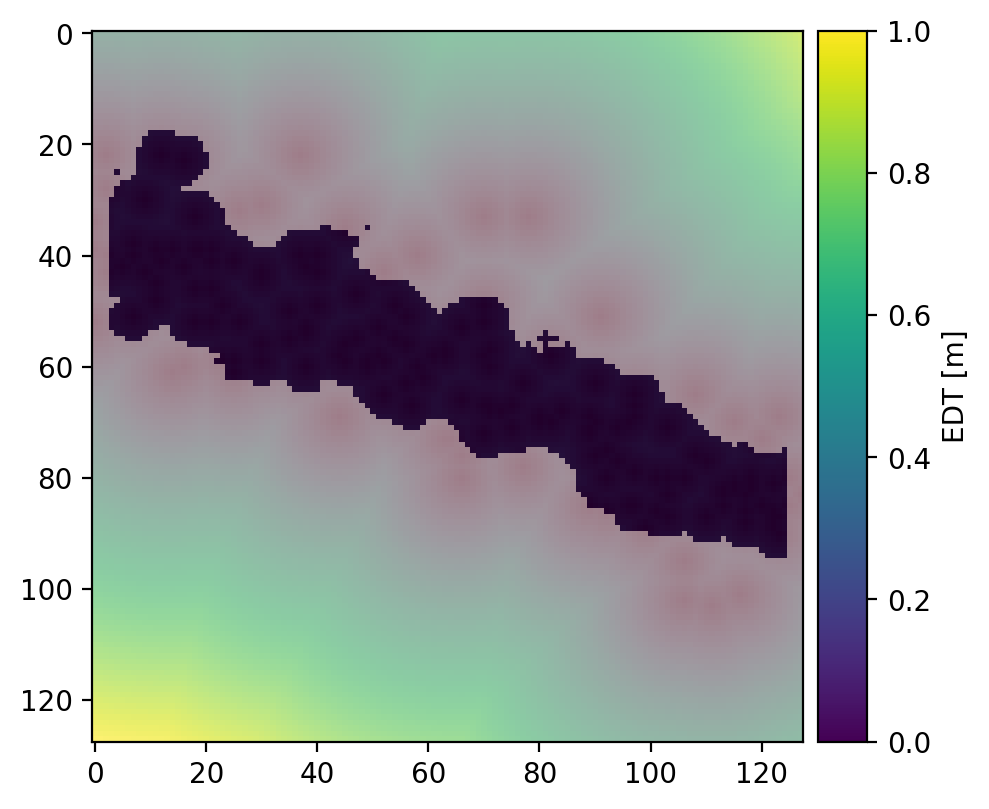

In [6]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## prediction images

In [5]:
data = np.load("../labelmaking/all_scaled_binary_train_label_EDT5_0_30726_res64_s5.npz")

edt = data['train'][:,:,:,0]
edt = np.expand_dims(edt, axis=-1)

best_model = tf.keras.models.load_model('edt5_b_64')

train_pred = best_model.predict(edt)
train_pred_thresholded = train_pred > 0.5

np.savez_compressed("../Photon_IoU/all_predicted_scaled_binary_EDT5_res64_order", pred=train_pred_thresholded)

187/187 [==============================] - 13s 67ms/step


In [11]:
# load data and best model
data = np.load("../labelmaking/all_scaled_binary_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0]
y_test = np.expand_dims(y_test, axis=-1)
best_model = tf.keras.models.load_model('edt2_b_64')

# prediction images
# predict ground probabilities for all train images
train_pred = best_model.predict(x_train)
# Convert sigmoid probability to classification
train_pred_thresholded = train_pred > 0.5

150/150 [==============================] - 10s 67ms/step


In [12]:
# predict ground probabilities for all test images
test_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
test_pred_thresholded = test_pred > 0.5

# load divider indices
ind_test = np.load('../labelmaking/all_concat_64_s5_indices_test.npy')
ind_train = np.load('../labelmaking/all_concat_64_s5_indices_train.npy')
ind_all = np.load('../labelmaking/all_concat_64_s5_indices.npy')

# divide
test_pred_mtns = test_pred_thresholded[:ind_test[0]]
test_pred_fhills = test_pred_thresholded[ind_test[0]:ind_test[1]]
test_pred_plains = test_pred_thresholded[ind_test[1]:]

train_pred_mtns =   train_pred_thresholded[:ind_train[0]]
train_pred_fhills = train_pred_thresholded[ind_train[0]:ind_train[1]]
train_pred_plains = train_pred_thresholded[ind_train[1]:]

# concatenate
all_predicted = np.concatenate((test_pred_mtns, train_pred_mtns, test_pred_fhills, train_pred_fhills, test_pred_plains, train_pred_plains))
print(all_predicted.shape)

38/38 [==============================] - 3s 68ms/step
(5974, 128, 128, 1)


In [13]:
np.savez_compressed("../Photon_IoU/all_predicted_scaled_binary_EDT2_res64", pred=all_predicted)